# Imports & Data Loading

In [ ]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.datasets import ImageFolder
import os

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khalidboussaroual/2d-geometric-shapes-17-shapes")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/2d-geometric-shapes-17-shapes


In [ ]:
# List top-level files/folders in the dataset
print(os.listdir(path))
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load full dataset
dataset = ImageFolder(root=os.path.join(path, '2D_Geometric_Shapes_Dataset'), transform=transform)
shape_classes = dataset.classes  # Save the correct class names
print("Total images available:", len(dataset))
print("Shape classes:", dataset.classes)

# Subset the dataset
subset_size = 200000  # smaller subset for faster training
subset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])
print("Using subset size:", len(subset))

# Split into train/test
train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train_dataset, test_dataset = random_split(subset, [train_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

['2D_Geometric_Shapes_Dataset']
Total images available: 850000
Shape classes: ['circle', 'decagon', 'heptagon', 'hexagon', 'kite', 'nonagon', 'octagon', 'oval', 'parallelogram', 'pentagon', 'rectangle', 'rhombus', 'semicircle', 'square', 'star', 'trapezoid', 'triangle']
Using subset size: 200000


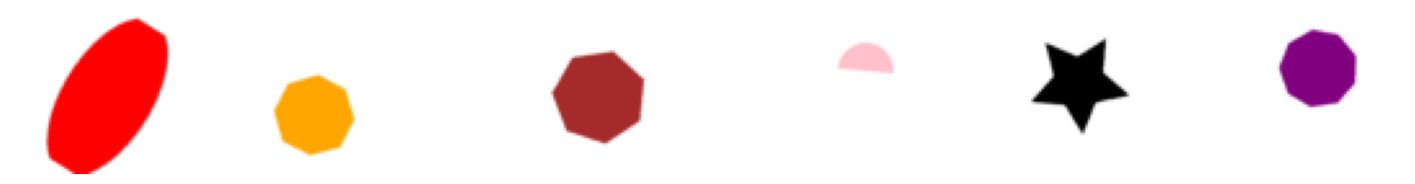

In [ ]:
# Get one batch
images, labels = next(iter(train_loader))

# Show the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(18, 4))
for i in range(6):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].axis("off")
plt.subplots_adjust(wspace=0.5)
plt.show()

# Classification & CNN Model


In [ ]:
# Shape classifier
class ShapeClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            # nn.Dropout(p=0.5),  # Add dropout after the first fully connected layer
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x



# Training Loop

In [ ]:
from tqdm import tqdm  # for the progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShapeClassifier(num_classes=17).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 13

# Initialize metric history lists
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)

    batch_iterator = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)

    for batch_idx, (images, labels) in enumerate(batch_iterator):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = output.argmax(1)
        running_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

        batch_iterator.set_postfix(loss=loss.item())

        # Check first batch for errors
        if epoch == 0 and batch_idx == 0:
            print("\n--- Debug Info (First Batch) ---")
            print("Labels:", labels[:10].cpu().numpy())
            print("Model raw outputs (logits):", output[:2].detach().cpu())
            print("Predicted classes:", output.argmax(1)[:10].cpu().numpy())
            print("--------------------------------\n")

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = running_correct / total_train

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)

    print(f"Epoch {epoch+1} Complete - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2%}")

    # Validation part
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = loss_fn(outputs, labels)

            val_running_loss += val_loss.item()
            preds = outputs.argmax(1)
            val_running_correct += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_running_loss / len(test_loader)
    val_accuracy = val_running_correct / total_val

    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2%}")


Epoch 1/13
------------------------------


Training Epoch 1:   0%|          | 1/5000 [00:01<1:57:40,  1.41s/it, loss=2.83]


--- Debug Info (First Batch) ---
Labels: [ 1  0  5  9 14 15  6  6 14 11]
Model raw outputs (logits): tensor([[-0.0538,  0.0562, -0.0952, -0.0764,  0.0715,  0.0170, -0.0933,  0.0141,
         -0.0179, -0.0777,  0.0343,  0.0505, -0.0366,  0.1253, -0.0358, -0.0784,
         -0.0413],
        [-0.0528,  0.0560, -0.0947, -0.0747,  0.0738,  0.0148, -0.0952,  0.0130,
         -0.0184, -0.0753,  0.0264,  0.0461, -0.0328,  0.1215, -0.0322, -0.0815,
         -0.0393]])
Predicted classes: [13 13 13 13 13 13 13 13 13 13]
--------------------------------



Epoch 1 Complete - Train Loss: 0.7219 - Train Acc: 73.41%
Validation Loss: 0.2044 - Validation Accuracy: 92.45%

Epoch 2/13
------------------------------


Epoch 2 Complete - Train Loss: 0.1689 - Train Acc: 93.40%
Validation Loss: 0.1037 - Validation Accuracy: 96.14%

Epoch 3/13
------------------------------


Epoch 3 Complete - Train Loss: 0.1050 - Train Acc: 96.04%
Validation Loss: 0.0690 - Validation Accuracy: 97.41%

Epoch 4/13
------------------------------


Epoch 4 Complete - Train Loss: 0.0837 - Train Acc: 96.96%
Validation Loss: 0.0829 - Validation Accuracy: 96.74%

Epoch 5/13
------------------------------


Epoch 5 Complete - Train Loss: 0.0694 - Train Acc: 97.49%
Validation Loss: 0.1462 - Validation Accuracy: 94.83%

Epoch 6/13
------------------------------


Epoch 6 Complete - Train Loss: 0.0585 - Train Acc: 97.88%
Validation Loss: 0.0447 - Validation Accuracy: 98.45%

Epoch 7/13
------------------------------


Epoch 7 Complete - Train Loss: 0.0560 - Train Acc: 97.99%
Validation Loss: 0.0571 - Validation Accuracy: 98.11%

Epoch 8/13
------------------------------


Epoch 8 Complete - Train Loss: 0.0481 - Train Acc: 98.35%
Validation Loss: 0.0391 - Validation Accuracy: 98.70%

Epoch 9/13
------------------------------


Epoch 9 Complete - Train Loss: 0.0474 - Train Acc: 98.39%
Validation Loss: 0.0348 - Validation Accuracy: 98.87%

Epoch 10/13
------------------------------


Epoch 10 Complete - Train Loss: 0.0436 - Train Acc: 98.51%
Validation Loss: 0.0382 - Validation Accuracy: 98.78%

Epoch 11/13
------------------------------


Epoch 11 Complete - Train Loss: 0.0394 - Train Acc: 98.68%
Validation Loss: 0.0929 - Validation Accuracy: 97.28%

Epoch 12/13
------------------------------


Epoch 12 Complete - Train Loss: 0.0402 - Train Acc: 98.71%
Validation Loss: 0.0378 - Validation Accuracy: 98.89%

Epoch 13/13
------------------------------


Epoch 13 Complete - Train Loss: 0.0354 - Train Acc: 98.84%
Validation Loss: 0.0289 - Validation Accuracy: 99.16%


# Plotting Training Statistics

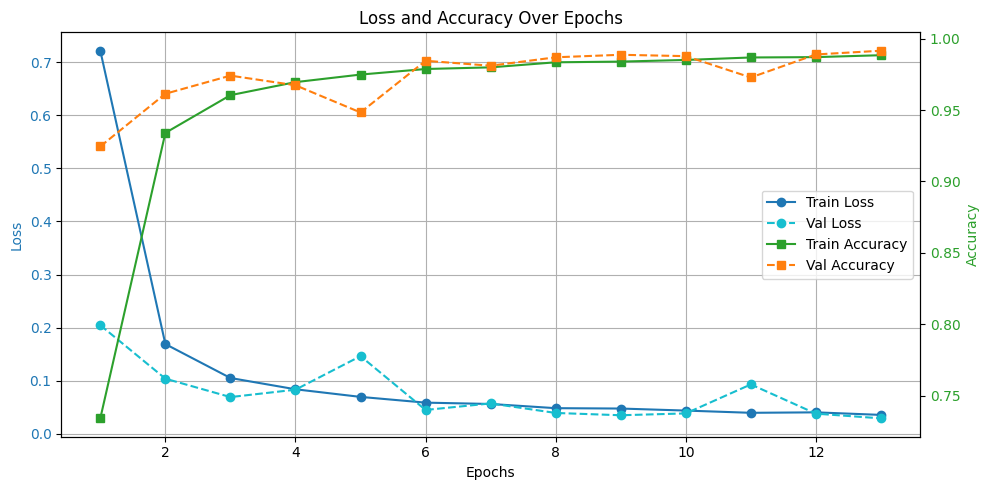

In [ ]:
epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot losses
color1 = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color1)
ax1.plot(epochs, train_loss_history, marker='o', label='Train Loss', color=color1)
ax1.plot(epochs, val_loss_history, marker='o', linestyle='--', label='Val Loss', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

# Second y-axis for accuracy
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Accuracy', color=color2)
ax2.plot(epochs, train_acc_history, marker='s', linestyle='-', label='Train Accuracy', color=color2)
ax2.plot(epochs, val_acc_history, marker='s', linestyle='--', label='Val Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Title
plt.title("Loss and Accuracy Over Epochs")
plt.tight_layout()
plt.show()

# Test Shape Recognition

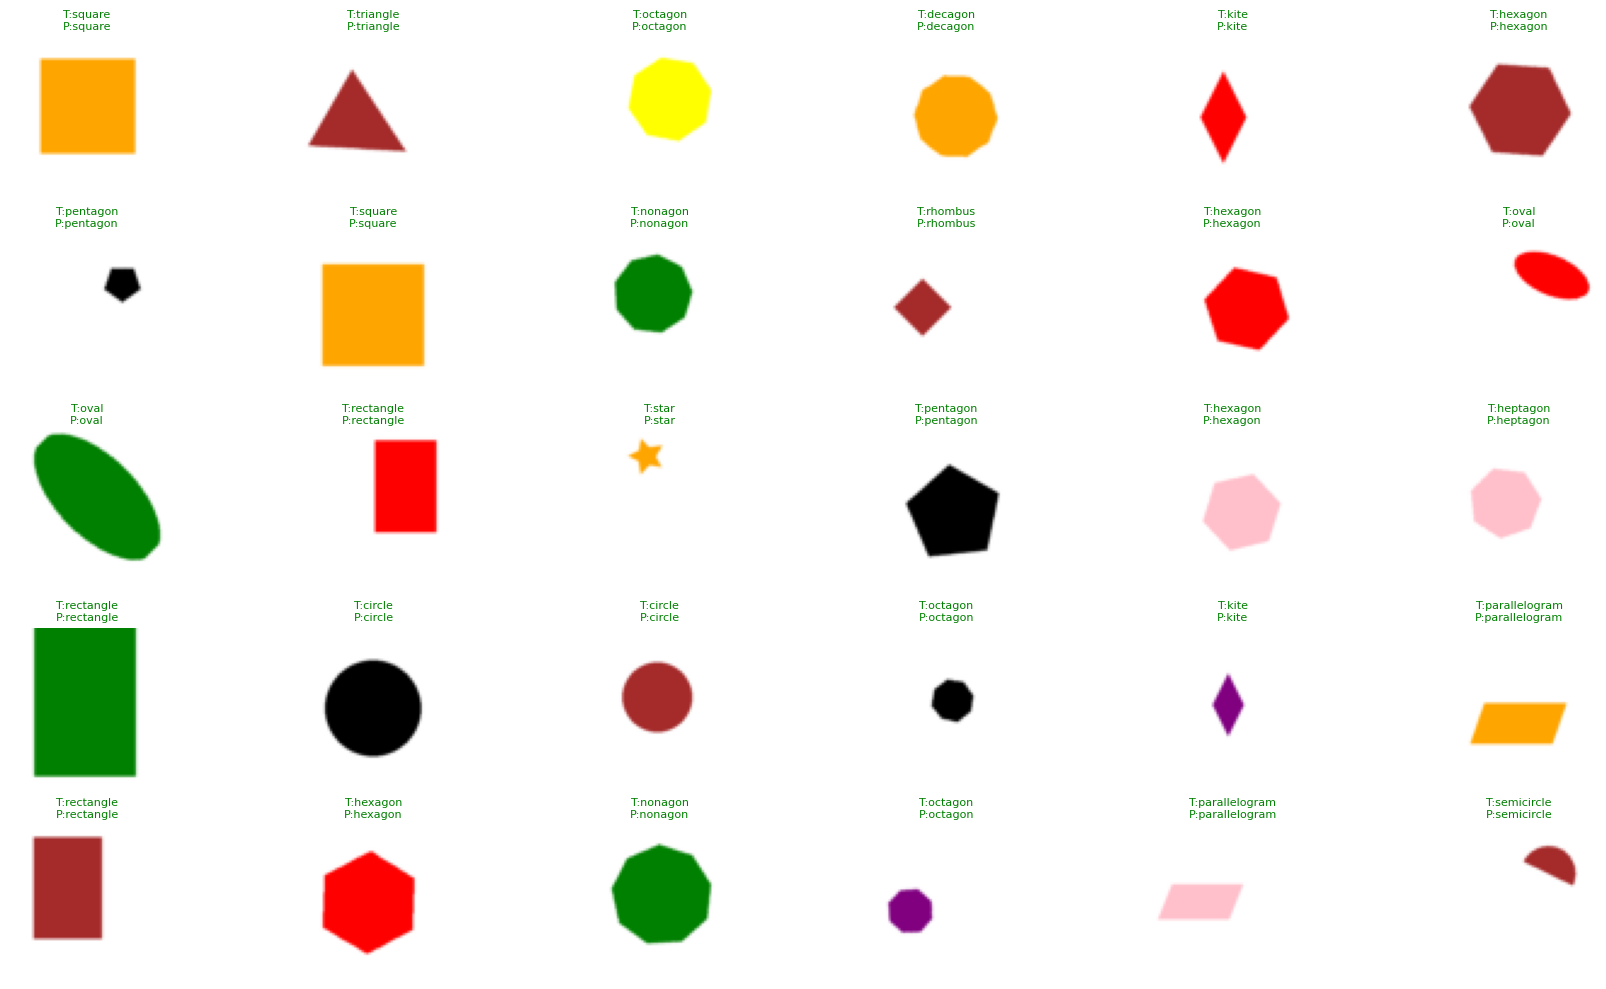

In [ ]:
# Visualize 30 Test Predictions with Colored Titles

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

model.eval()
outputs = model(images)
preds = outputs.argmax(1)

num_images = 30  # Number of images to show
rows = 5
cols = 6

plt.figure(figsize=(18, 10))  # Make it wide enough

for i in range(num_images):
    img = images[i].cpu().permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    true_label = shape_classes[labels[i].item()]
    pred_label = shape_classes[preds[i].item()]

    # Check if prediction is correct
    correct = (labels[i] == preds[i]).item()

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

    # Set title color based on correctness
    color = 'green' if correct else 'red'
    plt.title(f"T:{true_label}\nP:{pred_label}", fontsize=8, color=color)

plt.tight_layout()
plt.show()